# CMS Open Payments XGBOOST Model setup and deployment

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Purpose:** Setup AWS S3 Datalake for CMS Open Payments Data  
**Dataset:** CMS Open Payments Program Year 2024

---

## Table of Contents
1. [Environment Setup](#setup)
2. [AWS Configuration & S3 Bucket Creation](#aws-config)
3. [Download CMS Open Payments Data](#download)
4. [Upload Data to S3](#upload)
5. [Create Athena Database](#athena)
6. [Register Data with Athena](#register)
7. [Convert CSV to Parquet](#parquet)
8. [Query Data with AWS Data Wrangler](#query)
9. [Validation & Verification](#validation)


In [2]:
# retrieve the path variables from Notebook 01
%store -r bucket
%store -r database_name
%store -r table_name_parquet

In [3]:
%pip uninstall -y sagemaker sagemaker-core sagemaker-mlops sagemaker-serve sagemaker-train
%pip install "sagemaker<3" "boto3>=1.17.21"

Found existing installation: sagemaker 2.257.0
Uninstalling sagemaker-2.257.0:
  Successfully uninstalled sagemaker-2.257.0
Found existing installation: sagemaker-core 1.0.75
Uninstalling sagemaker-core-1.0.75:
  Successfully uninstalled sagemaker-core-1.0.75
Note: you may need to restart the kernel to use updated packages.
  Using cached sagemaker-2.257.0-py3-none-any.whl.metadata (17 kB)
  Using cached sagemaker_core-1.0.75-py3-none-any.whl.metadata (4.9 kB)
Using cached sagemaker-2.257.0-py3-none-any.whl (1.7 MB)
Using cached sagemaker_core-1.0.75-py3-none-any.whl (439 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sagemaker]/2 [sagemaker]
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install awswrangler pyathena

Note: you may need to restart the kernel to use updated packages.


In [5]:
import logging
logging.getLogger("sagemaker").setLevel(logging.ERROR)

In [6]:
import os
import boto3
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name

bucket = sess.default_bucket()
prefix = "CMS payments XGBOOST"



Unable to load JumpStart region config.
Traceback (most recent call last):
  File "/opt/conda/envs/sagemaker-recovery-mode/lib/python3.14/site-packages/sagemaker/jumpstart/constants.py", line 69, in _load_region_config
    with open(filepath) as f:
         ~~~~^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/opt/conda/envs/sagemaker-recovery-mode/lib/python3.14/site-packages/sagemaker/jumpstart/region_config.json'


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [7]:
print(role)
print(sess)
print(region)

arn:aws:iam::996351798934:role/LabRole
us-east-1


---
## Data sources

> Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

> Breast Cancer Wisconsin (Diagnostic) Data Set [https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)].

> _Also see:_ Breast Cancer Wisconsin (Diagnostic) Data Set [https://www.kaggle.com/uciml/breast-cancer-wisconsin-data].

## Data preparation


Let's download the data and save it in the local folder with the name data.csv and take a look at it.

In [8]:
import pandas as pd
import numpy as np
import awswrangler as wr
from datetime import datetime
#from sklearn.preprocessing import RobustScaler
#from sklearn.ensemble import IsolationForest

# retrieve the path variables from Notebook 01
%store -r bucket
%store -r database_name
%store -r table_name_parquet

# reload the cleaned dataset from S3
# This ensures 'df' is defined in this notebook's memory
print("Loading processed data from S3...")
df = wr.athena.read_sql_query(
    sql=f"SELECT * FROM {database_name}.{table_name_parquet} LIMIT 100000",
    database=database_name,
)

print(f"Environment ready. Dataframe shape: {df.shape}")

Loading processed data from S3...
Environment ready. Dataframe shape: (100000, 91)


In [49]:
bucket

'cmsopenpaymentsystemslight'

In [9]:
df.head()

,change_type,covered_recipient_type,teaching_hospital_ccn,teaching_hospital_id,teaching_hospital_name,covered_recipient_profile_id,covered_recipient_npi,covered_recipient_first_name,covered_recipient_middle_name,covered_recipient_last_name,...,associated_drug_or_biological_ndc_4,associated_device_or_medical_supply_pdi_4,covered_or_noncovered_indicator_5,indicate_drug_or_biological_or_device_or_medical_supply_5,product_category_or_therapeutic_area_5,name_of_drug_or_biological_or_device_or_medical_supply_5,associated_drug_or_biological_ndc_5,associated_device_or_medical_supply_pdi_5,payment_publication_date,program_year
0,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,2764824.0,1.144669e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024
1,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,146089.0,1.225341e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024
2,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,484538.0,1.255382e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024
3,NEW,Covered Recipient Non-Physician Practitioner,<NA>,NaN,<NA>,11385574.0,1.447985e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024
4,NEW,Covered Recipient Non-Physician Practitioner,<NA>,NaN,<NA>,10572077.0,1.104488e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024


In [10]:
df.head(3).T

,0,1,2
change_type,NEW,NEW,NEW
covered_recipient_type,Covered Recipient Physician,Covered Recipient Physician,Covered Recipient Physician
teaching_hospital_ccn,<NA>,<NA>,<NA>
teaching_hospital_id,NaN,NaN,NaN
teaching_hospital_name,<NA>,<NA>,<NA>
...,...,...,...
name_of_drug_or_biological_or_device_or_medical_supply_5,NaN,NaN,NaN
associated_drug_or_biological_ndc_5,NaN,NaN,NaN
associated_device_or_medical_supply_pdi_5,NaN,NaN,NaN
payment_publication_date,<NA>,06/30/2025,<NA>


In [11]:
#select only feature which has 50% or more non-null values
features = df.columns
print(f"Selected features with at least 50% non-null values: {features}")

Selected features with at least 50% non-null values: Index(['change_type', 'covered_recipient_type', 'teaching_hospital_ccn',
       'teaching_hospital_id', 'teaching_hospital_name',
       'covered_recipient_profile_id', 'covered_recipient_npi',
       'covered_recipient_first_name', 'covered_recipient_middle_name',
       'covered_recipient_last_name', 'covered_recipient_name_suffix',
       'recipient_primary_business_street_address_line1',
       'recipient_primary_business_street_address_line2', 'recipient_city',
       'recipient_state', 'recipient_zip_code', 'recipient_country',
       'recipient_province', 'recipient_postal_code',
       'covered_recipient_primary_type_1', 'covered_recipient_primary_type_2',
       'covered_recipient_primary_type_3', 'covered_recipient_primary_type_4',
       'covered_recipient_primary_type_5', 'covered_recipient_primary_type_6',
       'covered_recipient_specialty_1', 'covered_recipient_specialty_2',
       'covered_recipient_specialty_3', 'co

In [12]:
# restore feature and dataset splits

# turn non-date strings into NaT 
df['date_of_payment'] = pd.to_datetime(df['date_of_payment'], errors='coerce')

# check if we have too many NaTs (indicating a major schema shift)
nan_dates = df['date_of_payment'].isna().sum()
if nan_dates > 0:
    print(f"Warning: {nan_dates} rows had invalid date formats and were set to NaT.")

# fill NaT with a placeholder
df['date_of_payment'] = df['date_of_payment'].ffill().bfill()

df['payment_month'] = df['date_of_payment'].dt.month
df['is_weekend'] = (df['date_of_payment'].dt.dayofweek >= 5).astype(int)

print(f"Success: Features restored. New shape: {df.shape}")

Success: Features restored. New shape: (100000, 93)


/tmp/ipykernel_2636/1976128768.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_of_payment'] = pd.to_datetime(df['date_of_payment'], errors='coerce')


In [13]:
top_manu = df["applicable_manufacturer_or_applicable_gpo_making_payment_name"] \
              .value_counts() \
              .nlargest(100) \
              .index

df["manufacturer_clean"] = df[
    "applicable_manufacturer_or_applicable_gpo_making_payment_name"
].where(
    df["applicable_manufacturer_or_applicable_gpo_making_payment_name"].isin(top_manu),
    "OTHER"
)

In [14]:
df["manufacturer_avg_payment"] = df.groupby("manufacturer_clean")[
    "total_amount_of_payment_usdollars"
].transform("mean")

In [15]:
df.head()

,change_type,covered_recipient_type,teaching_hospital_ccn,teaching_hospital_id,teaching_hospital_name,covered_recipient_profile_id,covered_recipient_npi,covered_recipient_first_name,covered_recipient_middle_name,covered_recipient_last_name,...,product_category_or_therapeutic_area_5,name_of_drug_or_biological_or_device_or_medical_supply_5,associated_drug_or_biological_ndc_5,associated_device_or_medical_supply_pdi_5,payment_publication_date,program_year,payment_month,is_weekend,manufacturer_clean,manufacturer_avg_payment
0,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,2764824.0,1.144669e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,2024,12,0,100000000337,NaN
1,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,146089.0,1.225341e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,06/30/2025,2024,12,0,Organon Llc,9.243179e+01
2,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,484538.0,1.255382e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,2024,12,0,"Inc.)""",NaN
3,NEW,Covered Recipient Non-Physician Practitioner,<NA>,NaN,<NA>,11385574.0,1.447985e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,2024,12,0,OTHER,9.216643e+07
4,NEW,Covered Recipient Non-Physician Practitioner,<NA>,NaN,<NA>,10572077.0,1.104488e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,2024,12,0,100000000232,NaN


In [16]:
import numpy as np
import pandas as pd

# ---- Required columns ----
ID_COL = "covered_recipient_profile_id"          # change to covered_recipient_npi if you prefer
DATE_COL = "date_of_payment"
AMT_COL  = "total_amount_of_payment_usdollars"

# ---- Ensure types ----
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df[AMT_COL] = pd.to_numeric(df[AMT_COL], errors="coerce")

# ---- Sort for leakage-safe historical features ----
df = df.sort_values([ID_COL, DATE_COL]).reset_index(drop=True)

# ---- is_new_recipient: 1 if first payment for that recipient ----
df["is_new_recipient"] = (df.groupby(ID_COL).cumcount() == 0).astype(int)

# ---- hist_pay_avg: expanding mean of *prior* payments (shift(1) prevents leakage) ----
df["hist_pay_avg"] = (
    df.groupby(ID_COL)[AMT_COL]
      .expanding()
      .mean()
      .shift(1)
      .reset_index(level=0, drop=True)
)

# Fill first-payment NaNs with global median (robust default)
global_median = df[AMT_COL].median(skipna=True)
df["hist_pay_avg"] = df["hist_pay_avg"].fillna(global_median)

# ---- amt_to_avg_ratio: current amount divided by historical avg ----
df["amt_to_avg_ratio"] = df[AMT_COL] / df["hist_pay_avg"]
df["amt_to_avg_ratio"] = df["amt_to_avg_ratio"].replace([np.inf, -np.inf], np.nan).fillna(1.0)

# Optional: cap extreme ratios to keep things stable
df["amt_to_avg_ratio"] = df["amt_to_avg_ratio"].clip(lower=0, upper=20)

# Quick sanity peek
df[[ID_COL, DATE_COL, AMT_COL, "is_new_recipient", "hist_pay_avg", "amt_to_avg_ratio"]].head(10)

,covered_recipient_profile_id,date_of_payment,total_amount_of_payment_usdollars,is_new_recipient,hist_pay_avg,amt_to_avg_ratio
0,36.0,2024-11-04,125.00,1,20.080,6.225100
1,36.0,2024-12-19,23.33,0,125.000,0.186640
2,44.0,2024-04-22,28.26,1,74.165,0.381042
3,48.0,2024-05-29,NaN,1,28.260,1.000000
4,49.0,2024-06-07,120.86,1,20.080,6.018924
5,69.0,2024-01-11,16.98,1,120.860,0.140493
6,107.0,2024-03-05,7.98,1,16.980,0.469965
7,131.0,2024-01-23,NaN,1,7.980,1.000000
8,136.0,2024-02-12,16.46,1,20.080,0.819721
9,136.0,2024-03-05,NaN,0,16.460,1.000000


In [17]:
df.head()

,change_type,covered_recipient_type,teaching_hospital_ccn,teaching_hospital_id,teaching_hospital_name,covered_recipient_profile_id,covered_recipient_npi,covered_recipient_first_name,covered_recipient_middle_name,covered_recipient_last_name,...,associated_device_or_medical_supply_pdi_5,payment_publication_date,program_year,payment_month,is_weekend,manufacturer_clean,manufacturer_avg_payment,is_new_recipient,hist_pay_avg,amt_to_avg_ratio
0,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,36.0,1.003037e+09,NaN,NaN,NaN,...,NaN,06/30/2025,2024,11,0,ABBVIE INC.,6.973932e+01,1,20.080,6.225100
1,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,36.0,1.003037e+09,NaN,NaN,NaN,...,NaN,06/30/2025,2024,12,0,OTHER,9.216643e+07,0,125.000,0.186640
2,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,44.0,1.003045e+09,NaN,NaN,NaN,...,NaN,<NA>,2024,4,0,OTHER,9.216643e+07,1,74.165,0.381042
3,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,48.0,1.003049e+09,NaN,NaN,NaN,...,NaN,<NA>,2024,5,0,100000000234,NaN,1,28.260,1.000000
4,NEW,Covered Recipient Physician,<NA>,NaN,<NA>,49.0,1.003052e+09,NaN,NaN,NaN,...,NaN,06/30/2025,2024,6,0,OTHER,9.216643e+07,1,20.080,6.018924


In [18]:
df["physician_ownership_indicator"] = (
    df["physician_ownership_indicator"]
    .map({"Y":1, "N":0})
    .fillna(0)
)

df["third_party_payment_recipient_indicator"] = (
    df["third_party_payment_recipient_indicator"]
    .map({"Y":1, "N":0})
    .fillna(0)
)

df["high_risk"] = (
    (df["amt_to_avg_ratio"] > 4) |
    (df["total_amount_of_payment_usdollars"] > 10000)
).astype(int)

In [36]:
model_features = [

    # Core Financial Signal
    #'total_amount_of_payment_usdollars',       

    # Behavioral Features
    'hist_pay_avg',
    #'amt_to_avg_ratio',
     

    # Manufacturer Intelligence
    'manufacturer_avg_payment',   

    # Governance / Risk Indicators
    'physician_ownership_indicator',
    'third_party_payment_recipient_indicator',

    # Temporal Behavior
    'payment_month',
    'is_weekend',

    # Novelty / Pattern Break
    'is_new_recipient',
    
    # Target Variable
    'high_risk'
]

In [37]:
df_model = df[model_features]

In [38]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   hist_pay_avg                             100000 non-null  float64
 1   manufacturer_avg_payment                 66301 non-null   float64
 2   physician_ownership_indicator            100000 non-null  float64
 3   third_party_payment_recipient_indicator  100000 non-null  float64
 4   payment_month                            100000 non-null  int32  
 5   is_weekend                               100000 non-null  int64  
 6   is_new_recipient                         100000 non-null  int64  
 7   high_risk                                100000 non-null  int64  
dtypes: float64(4), int32(1), int64(3)
memory usage: 5.7 MB


In [24]:
!pip install scikit-learn -q

In [39]:
from sklearn.model_selection import train_test_split

X = df_model.drop("high_risk", axis=1)
y = df_model["high_risk"]

# First split train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Split temp into validation + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)


In [27]:
import sys
!{sys.executable} -m pip install xgboost -q

In [40]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,   # helps imbalance
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [41]:
from sklearn.metrics import roc_auc_score

preds = model.predict_proba(X_test)[:,1]

roc_auc_score(y_test, preds)

0.8398426589910495

In [42]:
from sklearn.metrics import average_precision_score

preds = model.predict_proba(X_test)[:,1]

average_precision_score(y_test, preds)

0.3839899154741418

In [47]:
!pip install matplotlib seaborn -q

====== MODEL PERFORMANCE ======

ROC-AUC: 0.840
PR-AUC:  0.384
F1 Score (0.5 threshold): 0.361

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     13955
           1       0.45      0.30      0.36      1045

    accuracy                           0.93     15000
   macro avg       0.70      0.64      0.66     15000
weighted avg       0.91      0.93      0.92     15000



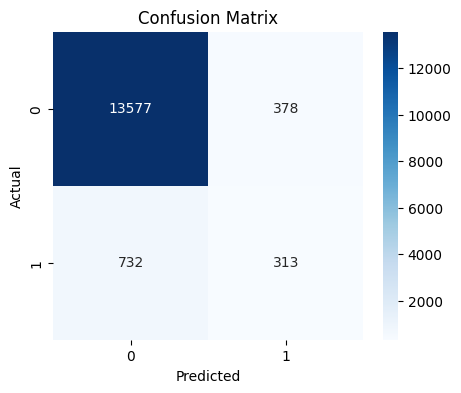


⭐ Best Threshold for F1: 0.424
Best F1 Score: 0.391


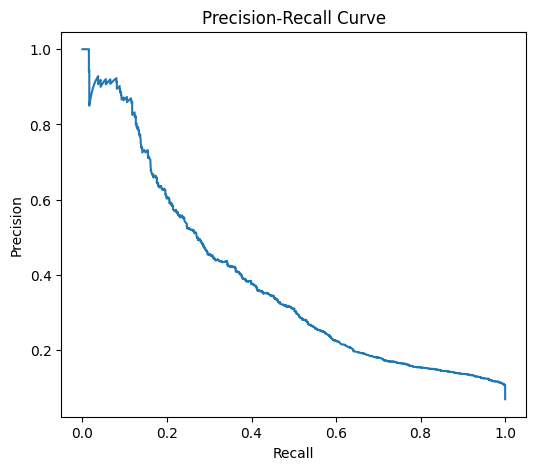

In [48]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Probabilities
pred_probs = model.predict_proba(X_test)[:,1]

# Default threshold
pred_labels = (pred_probs >= 0.5).astype(int)

print("====== MODEL PERFORMANCE ======\n")

print(f"ROC-AUC: {roc_auc_score(y_test, pred_probs):.3f}")
print(f"PR-AUC:  {average_precision_score(y_test, pred_probs):.3f}")
print(f"F1 Score (0.5 threshold): {f1_score(y_test, pred_labels):.3f}")

print("\nClassification Report:\n")
print(classification_report(y_test, pred_labels))


# -------------------------
# Confusion Matrix
# -------------------------

cm = confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# -------------------------
# Find BEST Threshold
# -------------------------

precision, recall, thresholds = precision_recall_curve(y_test, pred_probs)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n⭐ Best Threshold for F1: {best_threshold:.3f}")
print(f"Best F1 Score: {f1_scores[best_idx]:.3f}")


# Plot PR Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## SageMaker Feature Store (Offline Store on S3)
#Bucket: s3://cmsopenpaymentsystemslight

#Stores df_model into SageMaker Feature Store Offline Store (S3 + Glue/Athena table)

In [50]:

import time
import boto3
import pandas as pd
from datetime import datetime, timezone


import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup

In [53]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sess.default_bucket()
prefix = "feature-store/openpayments"
offline_store_s3_uri = f"s3://{bucket}/{prefix}/offline-store"

In [54]:
print("Using bucket:", bucket)
print("Offline store:", offline_store_s3_uri)

Using bucket: sagemaker-us-east-1-996351798934
Offline store: s3://sagemaker-us-east-1-996351798934/feature-store/openpayments/offline-store


In [55]:

# ---------------------------
# 1) Prepare dataframe for Feature Store
#    Must include: record identifier + event time
# ---------------------------
df_fs = df_model.copy()

# Choose record identifier:

if "record_id" in df_fs.columns:
    record_id_col = "record_id"
else:
    record_id_col = "fs_record_id"
    df_fs[record_id_col] = (
        pd.util.hash_pandas_object(df_fs, index=False)
        .astype("int64")
        .astype(str)
    )

event_time_col = "event_time"
df_fs[event_time_col] = datetime.now(timezone.utc).isoformat()

# Convert pandas string dtype to plain string/object
for c in df_fs.select_dtypes(include=["string"]).columns:
    df_fs[c] = df_fs[c].astype(str).fillna("")

# Ensure numeric dtypes are consistent
for c in df_fs.select_dtypes(include=["int32", "int64"]).columns:
    df_fs[c] = pd.to_numeric(df_fs[c], errors="coerce").fillna(0).astype("int64")

for c in df_fs.select_dtypes(include=["float32", "float64"]).columns:
    df_fs[c] = pd.to_numeric(df_fs[c], errors="coerce").astype("float64")

# ---------------------------
# 2) Create Feature Group (unique name)
# ---------------------------
feature_group_name = f"openpayments-light-features-{int(time.time())}"
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sess)

feature_group.load_feature_definitions(data_frame=df_fs)

feature_group.create(
    s3_uri=offline_store_s3_uri,
    record_identifier_name=record_id_col,
    event_time_feature_name=event_time_col,
    role_arn=role,
    enable_online_store=False,
)

print("Creating Feature Group:", feature_group_name)

# Wait until ACTIVE/Created
while True:
    status = feature_group.describe()["FeatureGroupStatus"]
    print("Status:", status)
    if status == "Created":
        break
    if status in ["CreateFailed", "DeleteFailed"]:
        raise RuntimeError(f"Feature group status: {status}")
    time.sleep(10)

# ---------------------------
# 3) Ingest dataframe to Offline Store (S3)
# ---------------------------
print("Ingesting to Feature Store Offline Store (S3)...")
feature_group.ingest(data_frame=df_fs, max_workers=4, wait=True)

desc = feature_group.describe()

print("\n✅ Done!")
print("Feature Group:", desc["FeatureGroupName"])
print("Record ID column:", record_id_col)
print("Event time column:", event_time_col)
print("Offline store S3 URI:", desc["OfflineStoreConfig"]["S3StorageConfig"]["S3Uri"])
print("Glue database:", desc["OfflineStoreConfig"]["DataCatalogConfig"]["Database"])
print("Glue table:", desc["OfflineStoreConfig"]["DataCatalogConfig"]["TableName"])

Creating Feature Group: openpayments-light-features-1770252595
Status: Creating
Status: Creating
Status: Created
Ingesting to Feature Store Offline Store (S3)...

✅ Done!
Feature Group: openpayments-light-features-1770252595
Record ID column: fs_record_id
Event time column: event_time
Offline store S3 URI: s3://sagemaker-us-east-1-996351798934/feature-store/openpayments/offline-store
Glue database: sagemaker_featurestore
Glue table: openpayments_light_features_1770252595_1770252595


In [56]:
desc = feature_group.describe()
desc["FeatureGroupStatus"], desc["OfflineStoreConfig"]["S3StorageConfig"]["S3Uri"]

('Created',
 's3://sagemaker-us-east-1-996351798934/feature-store/openpayments/offline-store')

In [57]:
s3_uri = feature_group.describe()["OfflineStoreConfig"]["S3StorageConfig"]["S3Uri"]
print(s3_uri)

s3://sagemaker-us-east-1-996351798934/feature-store/openpayments/offline-store


In [58]:
import awswrangler as wr

d = feature_group.describe()
db = d["OfflineStoreConfig"]["DataCatalogConfig"]["Database"]
tbl = d["OfflineStoreConfig"]["DataCatalogConfig"]["TableName"]

sample = wr.athena.read_sql_query(
    sql=f"SELECT * FROM {db}.{tbl} LIMIT 10",
    database=db
)
sample

,hist_pay_avg,manufacturer_avg_payment,physician_ownership_indicator,third_party_payment_recipient_indicator,payment_month,is_weekend,is_new_recipient,high_risk,fs_record_id,event_time,write_time,api_invocation_time,is_deleted


## Upload the Sagemaker Model created during our training job to the Sagemaker Model Registry

In [59]:
import joblib

model_path = "xgb_model.joblib"
joblib.dump(model, model_path)

print("Model saved locally.")

Model saved locally.


In [60]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()

s3_model_path = sess.upload_data(
    path=model_path,
    bucket=bucket,
    key_prefix="models/openpayments"
)

print("Model uploaded to:", s3_model_path)

Model uploaded to: s3://sagemaker-us-east-1-996351798934/models/openpayments/xgb_model.joblib


In [61]:
import boto3
import sagemaker
from sagemaker.image_uris import retrieve

region = boto3.Session().region_name
role = sagemaker.get_execution_role()

sm_client = boto3.client("sagemaker")

# Get official XGBoost container
image = retrieve(
    framework="xgboost",
    region=region,
    version="1.7-1"   # stable version
)

model_name = "openpayments-xgb-model"

primary_container = {
    "Image": image,
    "ModelDataUrl": s3_model_path
}

response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=primary_container
)

print("✅ Model ARN:")
print(response["ModelArn"])

✅ Model ARN:
arn:aws:sagemaker:us-east-1:996351798934:model/openpayments-xgb-model


## Part 1: Set Up Model Group

In [64]:
sm_client = boto3.client('sagemaker', region_name=region)
import time
model_package_group_name = "CMS-Payment-default" + str(round(time.time()))
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : "CMS-Payment-default model group"
}

create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:996351798934:model-package-group/CMS-Payment-default1770253647


In [65]:
sm_client.list_model_packages(ModelPackageGroupName=model_package_group_name)

{'ModelPackageSummaryList': [],
 'ResponseMetadata': {'RequestId': '3eac6ed9-ed56-423a-9040-e0caa3a7c029',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3eac6ed9-ed56-423a-9040-e0caa3a7c029',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '30',
   'date': 'Thu, 05 Feb 2026 01:07:34 GMT'},
  'RetryAttempts': 0}}

In [66]:
response = sm_client.describe_model_package_group(
    ModelPackageGroupName=model_package_group_name
)
response

{'ModelPackageGroupName': 'CMS-Payment-default1770253647',
 'ModelPackageGroupArn': 'arn:aws:sagemaker:us-east-1:996351798934:model-package-group/CMS-Payment-default1770253647',
 'ModelPackageGroupDescription': 'CMS-Payment-default model group',
 'CreationTime': datetime.datetime(2026, 2, 5, 1, 7, 27, 574000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:996351798934:user-profile/d-yz44u9kobd5z/default-1768850168304',
  'UserProfileName': 'default-1768850168304',
  'DomainId': 'd-yz44u9kobd5z',
  'IamIdentity': {'Arn': 'arn:aws:sts::996351798934:assumed-role/LabRole/SageMaker',
   'PrincipalId': 'AROA6P6ZR52LH3BHX4XRM:SageMaker'}},
 'ModelPackageGroupStatus': 'Completed',
 'ResponseMetadata': {'RequestId': 'db50f0e8-d69e-40cf-bd40-d9bb47465745',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'db50f0e8-d69e-40cf-bd40-d9bb47465745',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'c

## Part 2: Set Up Model Package

In [67]:
from sagemaker.image_uris import retrieve

image_uri = retrieve(
    framework="xgboost",
    region="us-east-1",
    version="1.7-1",
    instance_type="ml.m5.large"
)

print(image_uri)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1


In [69]:
import boto3

sm = boto3.client("sagemaker")
s3 = boto3.client("s3")

model_name = "openpayments-xgb-model"

# Get model info
model_desc = sm.describe_model(ModelName=model_name)

model_url = model_desc["PrimaryContainer"]["ModelDataUrl"]

print("Model URL:", model_url)

# Parse bucket + key
bucket = model_url.split("/")[2]
key = "/".join(model_url.split("/")[3:])

# Check object exists
s3.head_object(Bucket=bucket, Key=key)

print("✅ Model artifact exists in S3!")

Model URL: s3://sagemaker-us-east-1-996351798934/models/openpayments/xgb_model.joblib
✅ Model artifact exists in S3!


In [70]:
import boto3
import json
import time

sm = boto3.client("sagemaker")
region = boto3.Session().region_name

# ----- Model artifact in S3 -----
model_data_url = "s3://sagemaker-us-east-1-996351798934/models/openpayments/xgb_model.joblib"

# ----- Choose an inference image -----
# If you used built-in XGBoost image earlier, reuse it here:
# (If you already have `image` variable, keep that.)
from sagemaker.image_uris import retrieve
image = retrieve(framework="xgboost", region=region, version="1.7-1")

# ----- Create / Reuse a Model Package Group -----
model_package_group_name = "openpayments-xgb-model-group"  # pick a stable name
model_package_description = "OpenPayments risk model (XGBoost) trained on engineered features; registered for versioning."

# Create group (ignore if it already exists)
try:
    sm.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription=model_package_description
    )
    print(f"✅ Created Model Package Group: {model_package_group_name}")
except sm.exceptions.ResourceInUse:
    print(f"ℹ️ Model Package Group already exists: {model_package_group_name}")

# ----- (Optional but recommended) Add model metrics JSON in S3 -----
# If you have metrics like ROC/PR/F1, write them to S3 and reference them.
# If you don't want metrics right now, set `model_metrics = None`.
bucket = "sagemaker-us-east-1-996351798934"
metrics_key = f"model-metrics/openpayments/{int(time.time())}_metrics.json"
metrics_s3_uri = f"s3://{bucket}/{metrics_key}"

metrics_payload = {
    "roc_auc": 0.840,
    "pr_auc": 0.384,
    "f1_at_0_5": 0.361
}

s3 = boto3.client("s3")
s3.put_object(
    Bucket=bucket,
    Key=metrics_key,
    Body=json.dumps(metrics_payload).encode("utf-8"),
    ContentType="application/json"
)

model_metrics = {
    "ModelQuality": {
        "Statistics": {"ContentType": "application/json", "S3Uri": metrics_s3_uri}
    }
}

print("✅ Uploaded model metrics:", metrics_s3_uri)

# ----- Create Model Package (register a version) -----
create_pkg_resp = sm.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageDescription="XGBoost risk model package (offline features + engineered ratios).",
    InferenceSpecification={
        "Containers": [
            {
                "Image": image,
                "ModelDataUrl": model_data_url,
            }
        ],
        "SupportedContentTypes": ["text/csv", "application/json"],
        "SupportedResponseMIMETypes": ["text/csv", "application/json"],
    },
    ModelApprovalStatus="PendingManualApproval",  # or "Approved" if your prof allows
    ModelMetrics=model_metrics
)

model_package_arn = create_pkg_resp["ModelPackageArn"]
print("\n✅ Created Model Package ARN:\n", model_package_arn)

✅ Created Model Package Group: openpayments-xgb-model-group
✅ Uploaded model metrics: s3://sagemaker-us-east-1-996351798934/model-metrics/openpayments/1770253909_metrics.json

✅ Created Model Package ARN:
 arn:aws:sagemaker:us-east-1:996351798934:model-package/openpayments-xgb-model-group/1


In [73]:
import boto3

client = boto3.client("sagemaker")

response = client.describe_model_package(
    ModelPackageName="arn:aws:sagemaker:us-east-1:996351798934:model-package/openpayments-xgb-model-group/1"
)

print(response)

{'ModelPackageGroupName': 'openpayments-xgb-model-group', 'ModelPackageVersion': 1, 'ModelPackageRegistrationType': 'Registered', 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:996351798934:model-package/openpayments-xgb-model-group/1', 'ModelPackageDescription': 'XGBoost risk model package (offline features + engineered ratios).', 'CreationTime': datetime.datetime(2026, 2, 5, 1, 11, 50, 192000, tzinfo=tzlocal()), 'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1', 'ImageDigest': 'sha256:b4f13edb198529c460692015797fa1ca6a8ff1ed64a149297174d922121b8fc4', 'ModelDataUrl': 's3://sagemaker-us-east-1-996351798934/models/openpayments/xgb_model.joblib', 'ModelDataETag': 'f19a0720d763cdbf0790d6a6e25284fa', 'IsCheckpoint': False}], 'SupportedContentTypes': ['text/csv', 'application/json'], 'SupportedResponseMIMETypes': ['text/csv', 'application/json']}, 'ModelPackageStatus': 'Completed', 'ModelPackageStatusDetails': {'Valid

## Part 3: Write the Model Card

In [76]:
import boto3
import json
import time

sm = boto3.client("sagemaker")

MODEL_CARD_NAME = f"openpayments-xgb-model-card-{int(time.time())}"

# Put your identifiers here (optional but recommended)
MODEL_PACKAGE_ARN = "PASTE_YOUR_MODEL_PACKAGE_ARN_HERE"  # optional
MODEL_PACKAGE_GROUP = "openpayments-xgb-model-group"     # optional

MODEL_S3_ARTIFACT = "s3://sagemaker-us-east-1-996351798934/models/openpayments/xgb_model.joblib"
MODEL_NAME = "openpayments-xgb-model"

# ----- Minimal schema-compliant model card JSON -----
model_card_json = {
    "model_overview": {
        "model_description": "Binary classification model to flag potentially high-risk CMS Open Payments transactions for human-in-the-loop review.",
        "model_creator": "Tej",
        "model_owner": "Tej",
        "model_artifact": [MODEL_S3_ARTIFACT],
        "algorithm_type": "XGBoost",
        "problem_type": "Binary Classification",
    },
    "intended_uses": {
        "purpose_of_model": "Risk triage and prioritization of records for analyst review.",
        "intended_uses": "Offline screening/triage. Not intended for automated enforcement or punitive decisions without human review.",
        "factors_affecting_model_efficiency": "Proxy label quality, sampling strategy, missing values, and threshold selection affect performance.",
        "risk_rating": "Medium",
        "explanations_for_risk_rating": "Model uses weak supervision (proxy label) and may produce false positives; requires human review."
    },
    "additional_information": {
        "ethical_considerations": "Avoid automated enforcement. Evaluate subgroup performance where possible. Use as decision support only.",
        "caveats_and_recommendations": "Tune threshold based on operational cost tradeoffs; monitor drift and retrain on newer extracts."
    }
}

# IMPORTANT: Content must be a JSON string
content_str = json.dumps(model_card_json)

resp = sm.create_model_card(
    ModelCardName=MODEL_CARD_NAME,
    Content=content_str,
    ModelCardStatus="Draft",
    Tags=[
        {"Key": "ModelName", "Value": MODEL_NAME},
        {"Key": "ModelS3Artifact", "Value": MODEL_S3_ARTIFACT},
        {"Key": "ModelPackageGroup", "Value": MODEL_PACKAGE_GROUP},
        {"Key": "ModelPackageArn", "Value": MODEL_PACKAGE_ARN if MODEL_PACKAGE_ARN else "NA"},
    ],
)

print("✅ Model Card created")
print("ModelCardArn:", resp["ModelCardArn"])
print("ModelCardName:", MODEL_CARD_NAME)

✅ Model Card created
ModelCardArn: arn:aws:sagemaker:us-east-1:996351798934:model-card/openpayments-xgb-model-card-1770254170
ModelCardName: openpayments-xgb-model-card-1770254170


In [77]:
import boto3

client = boto3.client("sagemaker")

response = client.describe_model_card(
    ModelCardName=MODEL_CARD_NAME
)

response

{'ModelCardArn': 'arn:aws:sagemaker:us-east-1:996351798934:model-card/openpayments-xgb-model-card-1770254170',
 'ModelCardName': 'openpayments-xgb-model-card-1770254170',
 'ModelCardVersion': 1,
 'Content': '{"model_overview": {"model_description": "Binary classification model to flag potentially high-risk CMS Open Payments transactions for human-in-the-loop review.", "model_creator": "Tej", "model_owner": "Tej", "model_artifact": ["s3://sagemaker-us-east-1-996351798934/models/openpayments/xgb_model.joblib"], "algorithm_type": "XGBoost", "problem_type": "Binary Classification"}, "intended_uses": {"purpose_of_model": "Risk triage and prioritization of records for analyst review.", "intended_uses": "Offline screening/triage. Not intended for automated enforcement or punitive decisions without human review.", "factors_affecting_model_efficiency": "Proxy label quality, sampling strategy, missing values, and threshold selection affect performance.", "risk_rating": "Medium", "explanations_fo